In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('../data/reviews_with_ratings_cleaned.csv', index_col = 'Unnamed: 0', keep_default_na = False)
df.sample(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,avg_rating,avg_score_below_4,avg_score_below_5th_percentile,comments_clean
180594,29181009,450190611,2019-05-08,134401416,Lisa,I wish I could keep this wonderful gem to myse...,4.931429,0,0,i wish i could keep this wonderful gem to myse...
264024,50520639,1013787704360859279,2023-10-30,299530668,Adam,Place was well kept and clean. Ryan was respon...,4.947143,0,0,place was well kept and clean ryan was respons...
151247,22617173,518916170,2019-08-27,10286873,Linda,"Flat was good,and clean.Communication with Duv...",4.820000,0,0,flat was good and clean communication with duv...
210251,37212596,636179086,2020-07-09,46703243,Yasin,This place was a great value! Very clean and a...,4.941429,0,0,this place was a great value very clean and a ...
289875,595575667865210821,683369832021286780,2022-07-31,171879145,Caroline,"Perfect stay- great location, quiet, easy chec...",4.881429,0,0,perfect stay great location quiet easy check in


In [3]:
df.isnull().sum()

listing_id                        0
id                                0
date                              0
reviewer_id                       0
reviewer_name                     0
comments                          0
avg_rating                        0
avg_score_below_4                 0
avg_score_below_5th_percentile    0
comments_clean                    0
dtype: int64

#### Looking at below 5th percentile to see if I can improve the model

In [4]:
print(df['avg_score_below_5th_percentile'].value_counts()),
print('*'*30)
df['avg_score_below_5th_percentile'].value_counts(normalize = True)

avg_score_below_5th_percentile
0    320774
1      2033
Name: count, dtype: int64
******************************


avg_score_below_5th_percentile
0    0.993702
1    0.006298
Name: proportion, dtype: float64

In [5]:
X = df['comments_clean']
X.shape

(322807,)

In [6]:
y = df['avg_score_below_5th_percentile']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [13]:
pipe = Pipeline([
    ('cvec', CountVectorizer() ),
    ('logr', LogisticRegression(class_weight = 'balanced') )
])

In [14]:
pipe_params = {
    'cvec__stop_words' : ['english'],
    'cvec__max_features' : [5_000, 10_000, 30_000], 
    'cvec__min_df' : [2 ,5, 10, 25], # Minimum number of times a word needs to appear
    'cvec__ngram_range' : [ (1,1), (1,2), (1,3) ]
}

In [15]:
gs = GridSearchCV(pipe, pipe_params, n_jobs = -1, 
                  verbose = 10)

In [16]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [5000, 10000, 30000],
                         'cvec__min_df': [2, 5, 10, 25],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': ['english']},
             verbose=10)

#### Best Params - max_features is 30k, min_df is 10, n_gram range is (1,3)

In [12]:
gs.best_params_

{'tf__max_features': 30000,
 'tf__min_df': 10,
 'tf__ngram_range': (1, 3),
 'tf__stop_words': 'english'}

In [13]:
gs.best_score_

0.9346068854422669

#### Best score is 

In [17]:
gs.best_score_ - df['avg_score_below_5th_percentile'].value_counts(normalize = True)[0]

-0.05435761993544208

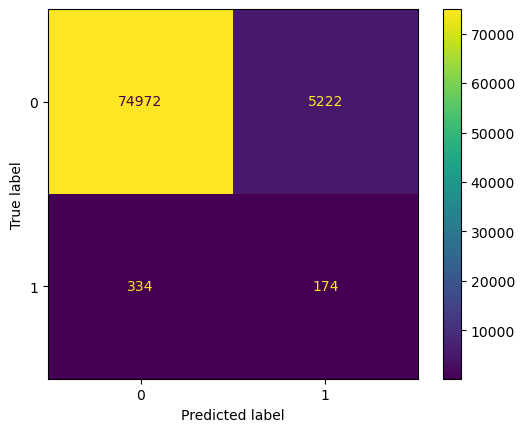

In [16]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test);

In [20]:
recall_score(y_test, gs.predict(X_test))

0.2421259842519685

In [22]:
prob_df = pd.DataFrame(gs.predict_proba(gs.best_estimator_.named_steps.cvec.get_feature_names_out() ), columns = ['above_5th_percentile', 'below_5th_percentile'])
prob_df

,above_5th_percentile,below_5th_percentile
0,0.653395,0.346605
1,0.604996,0.395004
2,0.346549,0.653451
3,0.486271,0.513729
4,0.322334,0.677666
...,...,...
29995,0.815211,0.184789
29996,0.093839,0.906161
29997,0.846194,0.153806
29998,0.833647,0.166353


In [23]:
feature_words = pd.DataFrame( gs.best_estimator_.named_steps.cvec.get_feature_names_out(), columns = ['features'])
feature_words

,features
0,00
1,00 pm
2,000
3,00am
4,10
...,...
29995,있어서
29996,있었습니다
29997,정말
29998,좋았습니다


In [26]:
word_probs = feature_words.join(prob_df)
word_probs.sort_values('below_5th_percentile', ascending = False).head(20)

,features,above_5th_percentile,below_5th_percentile
13958,jasmine,0.000307,0.999693
7409,dee,0.000972,0.999028
29921,yousong,0.001925,0.998075
27507,todd,0.002918,0.997082
21266,potomac river,0.003293,0.996707
6170,concierge,0.005412,0.994588
24209,short long term,0.005421,0.994579
7325,deal great,0.005999,0.994001
14097,juanita,0.007079,0.992921
27955,trip thanks,0.007218,0.992782


In [27]:
word_probs = feature_words.join(prob_df)
word_probs.sort_values('above_5th_percentile', ascending = False).head(20)

,features,above_5th_percentile,below_5th_percentile
16398,loved stay apartment,0.998893,0.001107
988,amazing location perfect,0.998793,0.001207
29713,wonderful location clean,0.998663,0.001337
20592,place just perfect,0.998638,0.001362
6949,david place perfect,0.998420,0.001580
26656,super clean convenient,0.998409,0.001591
16400,loved stay dc,0.998329,0.001671
29714,wonderful location close,0.998255,0.001745
27280,thoughtful touches make,0.998225,0.001775
26669,super clean perfect,0.998124,0.001876


In [28]:
pd.set_option('display.max_colwidth', 400)
df[['avg_rating', 'avg_score_below_4', 'comments_clean']] [df['comments_clean'].str.contains('jasmine')].sort_values('avg_rating')

,avg_rating,avg_score_below_4,comments_clean
302045,4.352857,0,initially at booking jasmine wasn t responsive to questions however as the date approached and came she was very responsive had all the items to help our holiday away from home feel homey enjoyed our stay
302043,4.352857,0,jasmine was very nice she was very responsive and made excellent recommendations public transit was very close by so even though there wasn t much to do in the area we were able to get where we needed with ease would stay again
302040,4.352857,0,a great place and responsive host the place was very nice and the instructions were clear mattresses were very comfortable the kitchen was very nice and clean and the living room was very nice jasmine was great at checking in and responding to a couple questions we had would definitely stay here again
302038,4.352857,0,jasmine house was very clean and nice and she got lots of kitchen equipment for people who like to cook we will be here again for sure
302037,4.352857,0,very cozy house and communication with jasmine was always very fluid everything was great
...,...,...,...
108491,4.902857,0,jasmine was so wonderful and quick to respond great host would definitely recommend this place to anyone visiting the dc area super clean home
108485,4.902857,0,sheridan s place was absolutely darling and immaculate i have been using airbnb for the past five years and i would rate this among the top places first the decor is very vibrant homey and stylish second the room is bright with lots of natural light and very clean it even has a nice airbnb magazine the bathroom is divine fully stocked with travel sized toiletries much like you would find in a ...
108473,4.902857,0,i use airbnb frequently when i travel but had never stayed in a private room listing sheridan s place has set the bar high the entire home was nice and well decorated the neighborhood was quiet and accessible to the metro line i was primarily using on my trip the other occupants were so cool and helped with any questions i had really would book again if i needed and recommend to anyone who is ...
299406,4.954286,0,one of the best apartment among 20 places i ve stayed sparkling clean brand new facilities great decor and comfy furnitures wonderful location walkable to all restaurants and stores not to mention the most wonderful host i ve ever met sabri martin jasmine are unbelievably kind thoughtful and accommodating always respond to our messages immediately solve problems proactively and willing to go e...
